# DQN (Deep Q Networks)

- Q함수의 모든 가능성을 계산하는 것이 아닌, Q함수를 **딥러닝 모형**으로 추정하자
- state을 input으로, 모든 가능한 action에 대한 Q(s, a)의 값을 output으로 출력한다!

> 단 input, output의 **독립성**을 위해 Experience replay buffer를 만들어서, 이 buffer에 여러 episode의 transition을 저장한다

- 그리고 y_hat에는 모수가 포함되게 되는데, 이를 위해 <u>main network와 target network를 따로 구성</u>한다. 하지만 이 둘은 같은 모형이며, 원래 network에서 추정된 모수를 일정시간 copy해서 고정해놓고, 추정에 사용한다!

In [1]:
pip install gym

In [2]:
import gym
env=gym.make('MsPacman-v0')
state=env.reset()
# env.render()

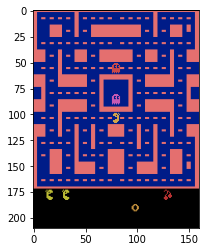

In [3]:
# state 보여주기
import gym
import matplotlib.pyplot as plt
%matplotlib inline
env=gym.make('MsPacman-v0')

render=lambda:plt.imshow(env.render(mode='rgb_array'))
env.reset()
for _ in range(10):
    env.step(env.action_space.sample())
    render()
    
env.close()

In [4]:
# state 정보
import numpy as np
print(state.shape)
state_1=state[1:176:2,::2]
print(state_1.shape)
state_1=state_1.mean(axis=2)  # 칼라 이미지를 흑백으로 만든다
print(state_1.shape)

state_1=state_1.reshape(88,80,1)  

print(state_1.shape)

state_1=state_1[np.newaxis,:]  # cnn의 input인 4D tensor를 만들기 위함!
print(state_1.shape)
print(env.action_space)

(210, 160, 3)
(88, 80, 3)
(88, 80)
(88, 80, 1)
(1, 88, 80, 1)
Discrete(9)


In [5]:
import random
from collections import deque  # reply buffer를 만들기 위함
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

import warnings 
warnings.filterwarnings('ignore')

state_shape=(88,80,1)   # 초기 state shape
action_size=env.action_space.n
color=np.array([210,164,74]).mean()

# (210)
def process_state(state):
    img=state[1:176:2,::2]  #downsize
    img=img.mean(axis=2)   #(210,160,3)을 (88,80)으로
    img[img==color]=0
    img=(img-128)/128 #-1~1
    img=img.reshape(88,80,1)
    return img

### DQN class 정의

In [6]:
class DQN:
    def __init__(self,state_shape,action_size):
        self.state_shape=state_shape
        self.action_size=action_size
        self.replay_buffer=deque(maxlen=5000)
        self.gamma=0.9
        self.update_timesteps=1000
        self.eps_min=0.1
        self.eps_max=0.8
        self.eps_steps=2000000
        self.main_network=self.q_network()
        self.target_network=self.q_network()
        self.target_network.set_weights=(self.main_network.get_weights())  # 모수 초기치를 copy
    
    # CNN Q 함수 layer 설계
    def q_network(self):
        model=Sequential()
        model.add(Conv2D(32,8,strides=4, padding='same', activation='relu', input_shape=self.state_shape))
        model.add(Conv2D(64,4,strides=2,padding='same',activation='relu'))
        model.add(Conv2D(64,3,padding='same',activation='relu'))
        model.add(Flatten())
        model.add(Dense(512,activation='relu'))
        model.add(Dense(128,activation='relu'))
        model.add(Dense(self.action_size,activation='linear'))
        model.compile(loss='mse',optimizer=Adam())
        return model
    
    # replay_buffer에 state, action, reward를 저장
    def store_transitions(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state,action,reward,next_state,done))
    
    # 입실론 그리디 함수    
    def epsilon_greedy(self,state,step):
        epsilon=max(self.eps_min,self.eps_max-(self.eps_max-self.eps_min)*step/self.eps_steps)
        if random.uniform(0,1)<epsilon:
            return np.random.randint(self.action_size)
        else:
            state=state[np.newaxis,:]
            Q_values=self.main_network.predict(state)
            return np.argmax(Q_values[0])  # Q value return 
        
    # Q함수를 학습시키는 함수      
    def train(self,batch_size):
        indices=np.random.randint(len(self.replay_buffer), size=batch_size)  # 임의로 추출하는 random 함수
        batch=[self.replay_buffer[index] for index in indices]
        
        states,actions,rewards,next_states,dones=[
            np.array([experience[field_index] for experience in batch]) for field_index in range(5)]
        
        next_Q_values=self.target_network.predict(next_states)  # CNN이 예측한 Q 함수 value
        max_next_Q_values=np.max(next_Q_values,axis=1)
        target_Q_values=(rewards+(1-dones)*self.gamma*max_next_Q_values)
        
        y_Q_values=self.main_network.predict(states)
        for k, action in enumerate(actions):
            y_Q_values[k][action]=target_Q_values[k]
            
        
        self.main_network.train_on_batch(states,y_Q_values)
        
    def update_target_network(self):
        self.target_network.set_weights=(self.main_network.get_weights())
       

학습이 너무 오래걸려서,,, 에피소드 500에서 50으로 줄였다!

In [8]:
num_episodes=50
num_timesteps=20000
batch_size=8
training_interval=4
return_monitor=[]
dqn=DQN(state_shape,action_size)
done=False
time_step=0

for i in range(num_episodes):
    Return=0
    state=process_state(env.reset())
    
    for t in range(num_timesteps):
        # env.render()
        time_step+=1
        if time_step % dqn.update_timesteps==0:
            dqn.update_target_network()
            
        action=dqn.epsilon_greedy(state,t*(i+1))
        next_state,reward,done,_ =env.step(action)
        next_state=process_state(next_state)
        
        dqn.store_transitions(state,action,reward,next_state,done)
        state=next_state
        
        Return+=reward
        
        if time_step % training_interval!=0:
            continue
        
        if done:
            print('Episode:' ,i, "," 'return:', Return)
            return_monitor.append([i,Return])
            break
            
        if len(dqn.replay_buffer)>batch_size:
            dqn.train(batch_size)

Episode: 0 ,return: 230.0
Episode: 1 ,return: 220.0
Episode: 2 ,return: 300.0
Episode: 3 ,return: 180.0
Episode: 4 ,return: 240.0
Episode: 5 ,return: 510.0
Episode: 6 ,return: 250.0
Episode: 7 ,return: 280.0
Episode: 8 ,return: 250.0
Episode: 9 ,return: 460.0
Episode: 10 ,return: 270.0
Episode: 11 ,return: 350.0
Episode: 12 ,return: 220.0
Episode: 13 ,return: 220.0
Episode: 14 ,return: 360.0
Episode: 15 ,return: 140.0
Episode: 16 ,return: 390.0
Episode: 17 ,return: 200.0
Episode: 18 ,return: 320.0
Episode: 19 ,return: 280.0
Episode: 20 ,return: 230.0
Episode: 21 ,return: 160.0
Episode: 22 ,return: 330.0
Episode: 23 ,return: 250.0
Episode: 24 ,return: 330.0
Episode: 25 ,return: 280.0
Episode: 26 ,return: 150.0
Episode: 27 ,return: 190.0
Episode: 28 ,return: 250.0
Episode: 29 ,return: 250.0
Episode: 30 ,return: 150.0
Episode: 31 ,return: 160.0
Episode: 32 ,return: 330.0
Episode: 33 ,return: 140.0
Episode: 34 ,return: 230.0
Episode: 35 ,return: 560.0
Episode: 36 ,return: 350.0
Episode: 37

In [9]:
a=(3,4,5)
b=np.zeros((3,6))
print(b)
for i, k in enumerate(a):
    b[i][k]=99
    
    
print(b)   

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[ 0.  0.  0. 99.  0.  0.]
 [ 0.  0.  0.  0. 99.  0.]
 [ 0.  0.  0.  0.  0. 99.]]


In [10]:
import pandas as pd
import plotly.express as px
df=pd.DataFrame(return_monitor,columns=['episode','return'])
fig=px.line(df,x='episode',y='return', title='Return_Monitor')
fig.show()

수렴이 되지 않고,,, 요동치는 모습이다. 아마 num_episodes가 매우 적어서 수렴이 어려워 보이긴 한다. 

# Double DQN

- Simple DQN이 y_hat을 모형에 의존하여 추정하기때문에, 과대 추정할 가능성이 높음을 인지

In [11]:
class DQN:
    def __init__(self,state_shape,action_size):
        self.state_shape=state_shape
        self.action_size=action_size
        self.replay_buffer=deque(maxlen=5000)
        self.gamma=0.9
        self.update_timesteps=1000
        self.eps_min=0.1
        self.eps_max=0.8
        self.eps_steps=2000000
        self.main_network=self.q_network()
        self.target_network=self.q_network()
        self.target_network.set_weights=(self.main_network.get_weights())  # 모수 초기치를 copy
    
    # CNN Q 함수 layer 설계
    def q_network(self):
        model=Sequential()
        model.add(Conv2D(32,8,strides=4, padding='same', activation='relu', input_shape=self.state_shape))
        model.add(Conv2D(64,4,strides=2,padding='same',activation='relu'))
        model.add(Conv2D(64,3,padding='same',activation='relu'))
        model.add(Flatten())
        model.add(Dense(512,activation='relu'))
        model.add(Dense(128,activation='relu'))
        model.add(Dense(self.action_size,activation='linear'))
        
        model.compile(loss='mse',optimizer=Adam())
        return model
    
    # replay_buffer에 state, action, reward를 저장
    def store_transitions(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state,action,reward,next_state,done))
    
    # 입실론 그리디 함수    
    def epsilon_greedy(self,state,step):
        epsilon=max(self.eps_min,self.eps_max-(self.eps_max-self.eps_min)*step/self.eps_steps)
        if random.uniform(0,1)<epsilon:
            return np.random.randint(self.action_size)
        else:
            state=state[np.newaxis,:]
            Q_values=self.main_network.predict(state)
            return np.argmax(Q_values[0])  # Q value return 
        
    # Q함수를 학습시키는 함수      
    def train(self,batch_size):
        indices=np.random.randint(len(self.replay_buffer), size=batch_size)  # 임의로 추출하는 random 함수
        batch=[self.replay_buffer[index] for index in indices]
        
        states,actions,rewards,next_states,dones=[
            np.array([experience[field_index] for experience in batch]) for field_index in range(5)]
        
        next_Q_values=self.main_network.predict(next_states)  # CNN이 예측한 Q 함수 value >> Double DQN으로 변경
        max_next_Q_values=np.max(next_Q_values,axis=1)
        target_Q_values=(rewards+(1-dones)*self.gamma*max_next_Q_values)
        
        y_Q_values=self.main_network.predict(states)
        for k, action in enumerate(actions):
            y_Q_values[k][action]=target_Q_values[k]
            
        
        self.main_network.train_on_batch(states,y_Q_values)
        
    def update_target_network(self):
        self.target_network.set_weights=(self.main_network.get_weights())
       

num_episodes=50
num_timesteps=20000
batch_size=8
training_interval=4
return_monitor=[]
dqn=DQN(state_shape,action_size)
done=False
time_step=0

for i in range(num_episodes):
    Return=0
    state=process_state(env.reset())
    
    for t in range(num_timesteps):
        # env.render()
        time_step+=1
        if time_step % dqn.update_timesteps==0:
            dqn.update_target_network()
            
        action=dqn.epsilon_greedy(state,t*(i+1))
        next_state,reward,done,_ =env.step(action)
        next_state=process_state(next_state)
        
        dqn.store_transitions(state,action,reward,next_state,done)
        state=next_state
        
        Return+=reward
        
        if time_step % training_interval!=0:
            continue
        
        if done:
            print('Episode:' ,i, "," 'return:', Return)
            return_monitor.append([i,Return])
            break
            
        if len(dqn.replay_buffer)>batch_size:
            dqn.train(batch_size)

Episode: 0 ,return: 320.0
Episode: 1 ,return: 300.0
Episode: 2 ,return: 340.0
Episode: 3 ,return: 280.0
Episode: 4 ,return: 350.0
Episode: 5 ,return: 150.0
Episode: 6 ,return: 290.0
Episode: 7 ,return: 120.0
Episode: 8 ,return: 120.0
Episode: 9 ,return: 200.0
Episode: 10 ,return: 290.0
Episode: 11 ,return: 160.0
Episode: 12 ,return: 240.0
Episode: 13 ,return: 190.0
Episode: 14 ,return: 350.0
Episode: 15 ,return: 160.0
Episode: 16 ,return: 200.0
Episode: 17 ,return: 370.0
Episode: 18 ,return: 280.0
Episode: 19 ,return: 470.0
Episode: 20 ,return: 310.0
Episode: 21 ,return: 170.0
Episode: 22 ,return: 220.0
Episode: 23 ,return: 160.0
Episode: 24 ,return: 170.0
Episode: 25 ,return: 230.0
Episode: 26 ,return: 250.0
Episode: 27 ,return: 240.0
Episode: 28 ,return: 240.0
Episode: 29 ,return: 170.0
Episode: 30 ,return: 340.0
Episode: 31 ,return: 490.0
Episode: 32 ,return: 280.0
Episode: 33 ,return: 340.0
Episode: 34 ,return: 200.0
Episode: 35 ,return: 140.0
Episode: 36 ,return: 200.0
Episode: 37

In [12]:
a=(3,4,5)
b=np.zeros((3,6))
print(b)
for i, k in enumerate(a):
    b[i][k]=99
    
    
print(b)   

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[ 0.  0.  0. 99.  0.  0.]
 [ 0.  0.  0.  0. 99.  0.]
 [ 0.  0.  0.  0.  0. 99.]]


In [13]:
import pandas as pd
import plotly.express as px
df=pd.DataFrame(return_monitor,columns=['episode','return'])
fig=px.line(df,x='episode',y='return', title='Return_Monitor')
fig.show()

에피소드의 수가 매우 적어서 그렇지만 gym에서는 double dqn이 좋다고 알려져있다. 